In [2]:
#!which python
#pwd

/Users/alkatiwari/opt/anaconda3/bin/python


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from matplotlib.colors import LogNorm
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Polygon
from rasterio.windows import from_bounds

Trying method 1: Using shapely polygon and reprojection...
Opening file: /Users/alkatiwari/Documents/FloodMapping/EnviroAtlas/2020_Dasymetric_Population_CONUS_V1_1/2020_Dasymetric_Population_CONUS_V1_1.tif
Raster CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Reprojecting Texas boundary from EPSG:4326 to raster CRS
Extracting Texas data from raster...
Saving Texas subset to: /Users/alkatiwari/Documents/FloodMapping/EnviroAtlas/2020_Dasymetr

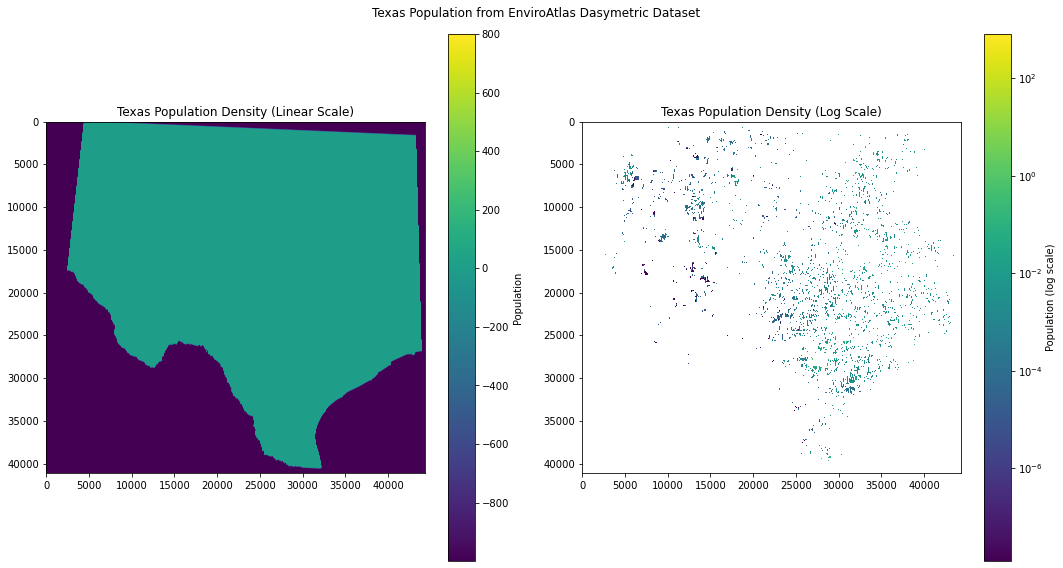

In [5]:


def visualize_texas_subset(tif_path):
    """
    Visualize Texas subset of a TIF file with population data using a logarithmic color scale
    
    Parameters:
    tif_path (str): Path to the TIF file
    """
    # Check if the file exists
    if not os.path.exists(tif_path):
        print(f"Error: File not found at {tif_path}")
        return
    
    try:
        print(f"Opening file: {tif_path}")
        with rasterio.open(tif_path) as src:
            print(f"Raster CRS: {src.crs}")
            
            # Define Texas bounding box (approximate) in WGS84
            # Texas bounds (minx, miny, maxx, maxy) in EPSG:4326 (WGS84)
            texas_bounds_wgs84 = (-106.65, 25.84, -93.51, 36.50)
            
            # Create a polygon geometry for Texas using the bounds
            texas_box = Polygon([
                (texas_bounds_wgs84[0], texas_bounds_wgs84[1]),  # lower left
                (texas_bounds_wgs84[0], texas_bounds_wgs84[3]),  # upper left
                (texas_bounds_wgs84[2], texas_bounds_wgs84[3]),  # upper right
                (texas_bounds_wgs84[2], texas_bounds_wgs84[1]),  # lower right
                (texas_bounds_wgs84[0], texas_bounds_wgs84[1])   # close the polygon
            ])
            
            # Create a GeoDataFrame with the Texas box
            texas_gdf = gpd.GeoDataFrame(geometry=[texas_box], crs="EPSG:4326")
            
            # Reproject to match raster CRS
            print(f"Reprojecting Texas boundary from EPSG:4326 to raster CRS")
            texas_gdf = texas_gdf.to_crs(src.crs)
            
            # Get the geometry in GeoJSON-like format for rasterio
            texas_geom = [mapping(geom) for geom in texas_gdf.geometry]
            
            # Mask the raster with Texas boundary
            print("Extracting Texas data from raster...")
            masked_data, masked_transform = mask(src, texas_geom, crop=True)
            
            # Get metadata for the masked subset
            meta = src.meta.copy()
            meta.update({
                "driver": "GTiff",
                "height": masked_data.shape[1],
                "width": masked_data.shape[2],
                "transform": masked_transform
            })
            
            # Create output paths
            output_dir = os.path.dirname(tif_path)
            texas_tif_path = os.path.join(output_dir, 'texas_dasymetric_population.tif')
            visualization_path = os.path.join(output_dir, 'texas_population_visualization.png')
            
            # Save the masked data as a new GeoTIFF
            print(f"Saving Texas subset to: {texas_tif_path}")
            with rasterio.open(texas_tif_path, 'w', **meta) as dst:
                dst.write(masked_data)
            
            # Extract the data for visualization (first band)
            data = masked_data[0]
            print(f"Texas subset shape: {data.shape}")
            
            # Create a figure with two subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
            
            # Standard visualization
            img1 = ax1.imshow(data, cmap='viridis')
            ax1.set_title('Texas Population Density (Linear Scale)')
            plt.colorbar(img1, ax=ax1, label='Population')
            
            # Filter out no-data values for better visualization
            # Assuming 0 or negative values are no-data
            data_masked = np.ma.masked_less_equal(data, 0)
            
            # Logarithmic scale visualization for better population distribution viewing
            img2 = ax2.imshow(data_masked, cmap='viridis', norm=LogNorm())
            ax2.set_title('Texas Population Density (Log Scale)')
            plt.colorbar(img2, ax=ax2, label='Population (log scale)')
            
            # Add file name as overall title
            plt.suptitle(f"Texas Population from EnviroAtlas Dasymetric Dataset")
            
            # Adjust layout and display
            plt.tight_layout()
            print(f"Saving visualization to: {visualization_path}")
            plt.savefig(visualization_path, dpi=300)
            plt.show()
            
    except Exception as e:
        print(f"Error reading or visualizing the TIF file: {e}")
        import traceback
        traceback.print_exc()

def visualize_with_window(tif_path):
    """
    Alternative method: Visualize a portion of a TIF file using windows
    
    Parameters:
    tif_path (str): Path to the TIF file
    """
    if not os.path.exists(tif_path):
        print(f"Error: File not found at {tif_path}")
        return
    
    try:
        print(f"Opening file: {tif_path}")
        with rasterio.open(tif_path) as src:
            print(f"Raster CRS: {src.crs}")
            
            # Getting raster bounds
            raster_bounds = src.bounds
            print(f"Full raster bounds: {raster_bounds}")
            
            # For Albers projection used in the EnviroAtlas dataset
            # These are approximate bounds for Texas in Albers coordinates
            # Measured in meters from the projection center
            # You may need to adjust these values
            texas_albers_bounds = (-1000000, -700000, 0, 700000)
            
            print(f"Using Texas bounds (Albers): {texas_albers_bounds}")
            
            # Create window from the bounds
            window = from_bounds(*texas_albers_bounds, src.transform)
            
            # Read data in the window
            data = src.read(1, window=window)
            
            print(f"Extracted data shape: {data.shape}")
            
            # Create a figure with two subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
            
            # Standard visualization
            img1 = ax1.imshow(data, cmap='viridis')
            ax1.set_title('Texas Population Density (Linear Scale)')
            plt.colorbar(img1, ax=ax1, label='Population')
            
            # Filter out no-data values for better visualization
            data_masked = np.ma.masked_less_equal(data, 0)
            
            # Logarithmic scale visualization
            img2 = ax2.imshow(data_masked, cmap='viridis', norm=LogNorm())
            ax2.set_title('Texas Population Density (Log Scale)')
            plt.colorbar(img2, ax=ax2, label='Population (log scale)')
            
            plt.suptitle(f"Texas Population from EnviroAtlas Dasymetric Dataset")
            plt.tight_layout()
            
            # Save visualization
            output_dir = os.path.dirname(tif_path)
            plt.savefig(os.path.join(output_dir, 'texas_population_window_visualization.png'), dpi=300)
            plt.show()
            
    except Exception as e:
        print(f"Error in window-based visualization: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    # Path to the TIF file
    tif_file = "/Users/alkatiwari/Documents/FloodMapping/EnviroAtlas/2020_Dasymetric_Population_CONUS_V1_1/2020_Dasymetric_Population_CONUS_V1_1.tif"
    
    # Try both methods in sequence
    try:
        print("Trying method 1: Using shapely polygon and reprojection...")
        visualize_texas_subset(tif_file)
    except Exception as e:
        print(f"Method 1 failed: {e}")
        print("\nTrying method 2: Using window from Albers bounds...")
        visualize_with_window(tif_file)